20 image files for caliberation.
Resize image  calibration7.jpg (721, 1281)
Failed to find corners for calibration4.jpg
Resize image  calibration15.jpg (721, 1281)
Failed to find corners for calibration15.jpg
Failed to find corners for calibration5.jpg
Failed to find corners for calibration1.jpg
[[  1.24227546e+03   0.00000000e+00   7.07457606e+02]
 [  0.00000000e+00   1.25189343e+03   3.71340251e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[ -2.58153319e-01  -1.77477148e-01   3.18044588e-03  -2.58038047e-04
    7.02772180e-01]]
16
16


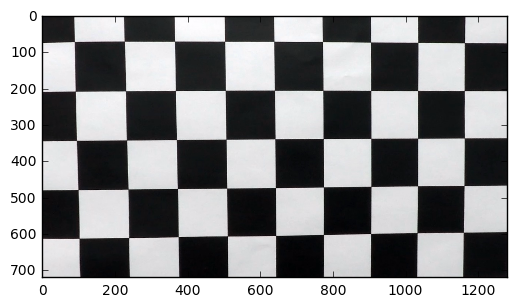

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

%matplotlib inline

objpoints = []
imgpoints = []

image_dir = './camera_cal'

image_files = os.listdir(image_dir)

print("%d image files for caliberation." % len(image_files))
corner_shape = (9, 6)
gray_shape = (720, 1280)

objp = np.zeros((9*6, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

for image_file in image_files:
    img = cv2.imread(os.path.join(image_dir, image_file))
    # print(image_file, img.shape)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    if gray.shape != gray_shape:
        print("Resize image ", image_file, gray.shape)
        gray = cv2.resize(gray, gray_shape)
    ret, corners = cv2.findChessboardCorners(gray, corner_shape,None)
    if ret is True:
        imgpoints.append(corners)
        objpoints.append(objp)
    else:
        print("Failed to find corners for %s" % image_file)
        #plt.imshow(img)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, gray_shape[::-1], None, None)

print(mtx)

print(dist)

print(len(rvecs))
print(len(tvecs))

test_img = cv2.imread(os.path.join(image_dir, 'calibration1.jpg'))
dst = cv2.undistort(test_img, mtx, dist, None, mtx)
plt.imshow(dst)

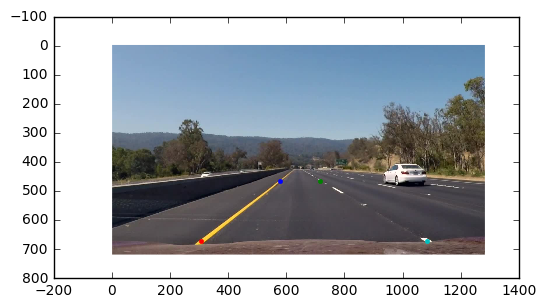

In [2]:
# Sampled one image frame from project_video.mp4 at 16th second, which has two straight lanes 
# ffmpeg -i project_video.mp4 -ss 00:00:16.000 -f image2 -vframes 1 sampled_frame.jpg
from numpy.random import rand

img = mpimg.imread('./output_images/sampled_frame.jpg')
#img = mpimg.imread('./output_images/sampled_challenge_frame17.jpg')
#img = mpimg.imread('./test/test1.jpg')

# Plot four selected points on image
plt.imshow(img)
plt.plot(577, 464, '.') # top left point
plt.plot(715, 464, '.') # top right point
plt.plot(307, 672, '.') # bottom left point
plt.plot(1084, 672, '.') # bottom right point


Get the perspective matrix that can warp the image to a perspective of view from above.

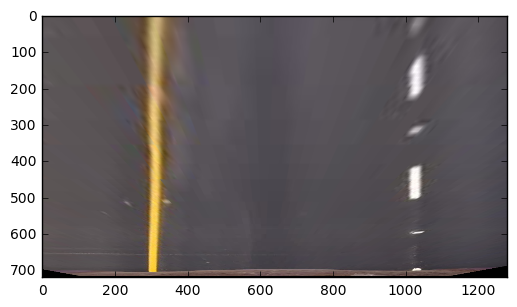

In [3]:
src = np.float32([[577, 464], [715, 464], [1084, 672], [307, 672]])
dst = np.float32([[300, 200], [1030, 200], [1030, 700], [300, 700]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]),
                             flags=cv2.INTER_LINEAR)
plt.imshow(warped)

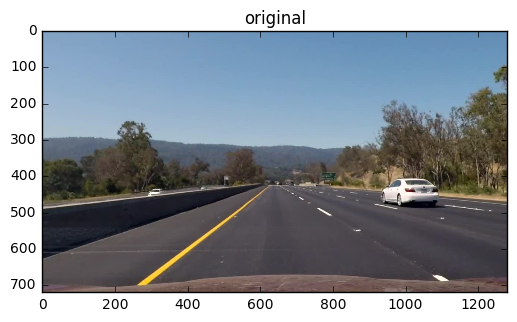

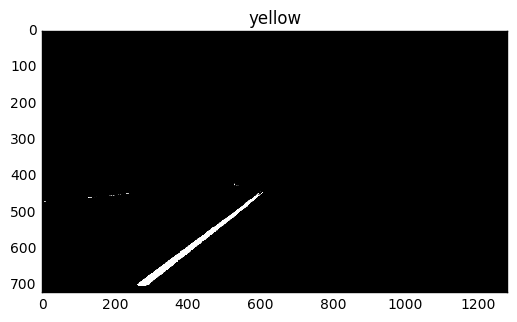

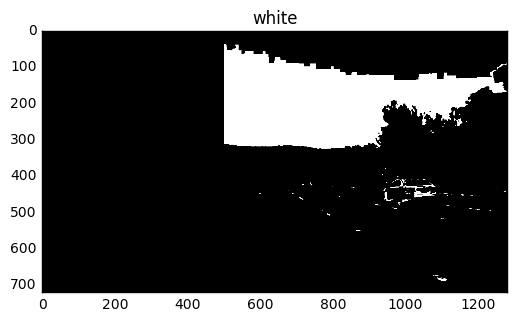

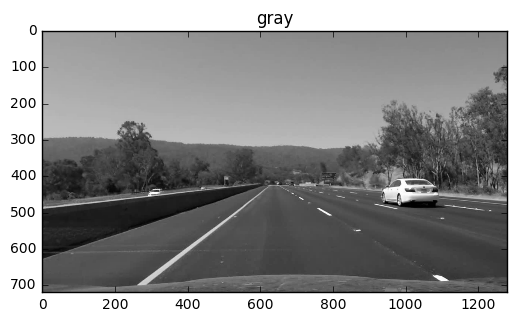

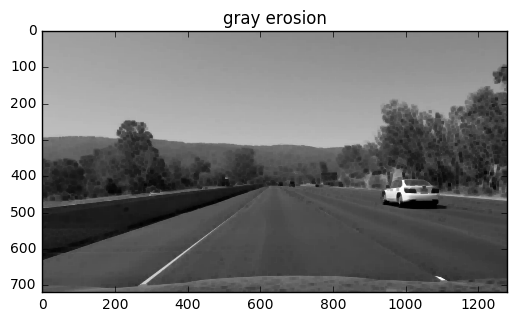

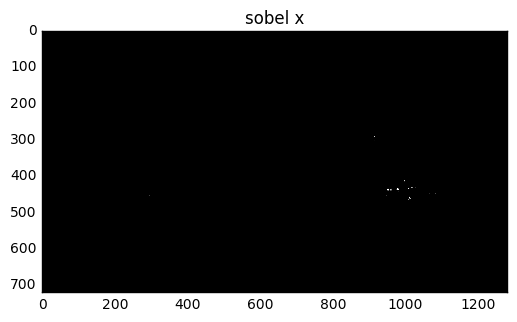

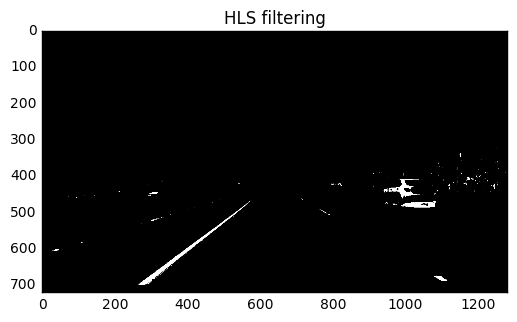

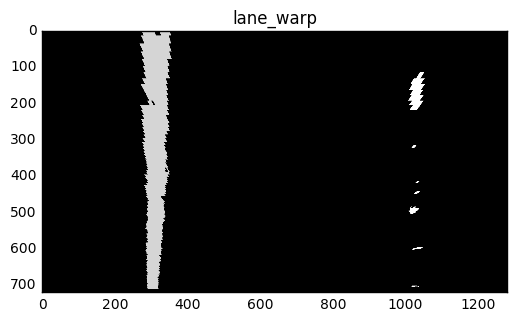

In [4]:
def transform_image(orginal_img):
    '''
    Transform a camera image by applying undistortion and
    perspective transform
    original_img: the original camera image
    '''
    undistorted = cv2.undistort(original_img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(undistorted, M,
                                 (undistored.shape[1], undistored.shape[0]),
                                 flags=cv2.INTER_LINEAR)
    return warped

def abs_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    '''
    Function to do sobel edge detection and thresholding
    img: original image
    orient: the direction of sobel detection, 'x' or 'y'
    thresh_min: minimum threshold
    thresh_max: maximum threshold
    '''
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # plt.imshow(sxbinary, cmap='gray')
    return sxbinary
    
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def combined_sobel(img, use_saturation=True):
    '''
    NOT USED for now
    Do a few sobel based detections and combine the results together
    '''
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    if not use_saturation:
        channel_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        channel_img = hls[:,:,2]
    gradx = abs_thresh(channel_img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_thresh(channel_img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(channel_img, sobel_kernel=ksize, mag_thresh=(5, 100))
    dir_binary = dir_threshold(channel_img, sobel_kernel=ksize, thresh=(0.5, 1.2))
    combined = np.zeros_like(dir_binary)
    # combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[((gradx == 1) & (grady == 1))] = 1
    return combined

def hls_filter(img, thresh=(170, 255)):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s = cv2.equalizeHist(s_channel)
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary
    
# NOT USED
def combined_filters(img, sobel_thresh=(35, 150), hls_thresh=(30, 255)):
    '''
    Combines a x sobel filter and a saturation channel filter.
    '''
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ksize = 3
    # Threshold x gradient
    sxbinary = abs_thresh(gray, orient='x', sobel_kernel=ksize, thresh=sobel_thresh)
    # sxbinary = combined_sobel(img)
    sobel_binary = sxbinary
    
    # Threshold color channel
    s_binary = hls_filter(img, thresh=hls_thresh)

    #plt.figure(1)
    #plt.imshow(img)
    #plt.figure(2)
    #plt.imshow(s_binary, cmap='gray')
    #plt.figure(3)
    #plt.imshow(sxbinary, cmap='gray')
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sobel_binary == 1)] = 1
    return combined_binary

# A combined filter that combines color (yellow/white) filtering, sobel filtering,
# and saturation channel (from HLS) filtering
def combined_filters2(img, sth=(35, 100),
                      y=([0, 100, 100], [50, 255, 255]),
                      w=([20, 0, 170], [255, 100, 255]), visualize=False):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv = cv2.GaussianBlur(hsv, (3, 3), 0)
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]
    #mpimg.imsave('h', h, cmap=plt.cm.gray)
    #mpimg.imsave('s', s, cmap=plt.cm.gray)
    #mpimg.imsave('v', v, cmap=plt.cm.gray)
    
    yellow_binary = np.zeros_like(h)
    yellow_binary[(h >= y[0][0]) & (h <= y[1][0]) & (s >= y[0][1])
                  & (s <= y[1][1]) & (v >= y[0][2]) & (v <= y[1][2])] =1
    yellow_binary[:, 700:] = 0
    white_binary = np.zeros_like(h)
    white_binary[(h >= w[0][0]) & (h <= w[1][0]) & (s >= w[0][1])
                  & (s <= w[1][1]) & (v >= w[0][2]) & (v <= w[1][2])] =1
    white_binary[:, :500] = 0
    
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #gray = cv2.equalizeHist(gray)
    ksize = 3
    # Threshold x gradient
    sxbinary = abs_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    # !! Use sobel edge detector, but only for bright colors, not dark lines
    # So to remove dark lines/splits on the road.
    kernel = np.ones((ksize+3,ksize+3),np.uint8)
    erosion = cv2.erode(gray,kernel,iterations = 1)
    sxbinary[erosion < 155] = 0
    
    # Saturation channel filtering from HLS
    hls_binary = hls_filter(img, thresh=(170, 255))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(yellow_binary == 1)] = 50
    combined_binary[(white_binary == 1) & (combined_binary == 0)] = 60
    #sxbinary[:, :600] = 0
    #sxbinary[500:, :] = 0
    combined_binary[(sxbinary == 1) & (combined_binary == 0)] = 15
    # S channel
    #combined_binary[(hls_binary == 1) & (combined_binary == 0)] = 10
    combined_binary[:420, :] = 0
    #combined_binary[(yellow_binary == 1) | (white_binary == 1) | (sxbinary == 1)] = 1

    if visualize:
        plt.figure(1)
        plt.title('original')
        plt.imshow(img)
        plt.figure(2)
        plt.title('yellow')
        plt.imshow(yellow_binary, cmap='gray')
        plt.figure(3)
        plt.title('white')
        plt.imshow(white_binary, cmap='gray')
        plt.figure(4)
        plt.title('gray')
        plt.imshow(gray, cmap='gray')
        plt.figure(5)
        plt.title('gray erosion')
        plt.imshow(erosion, cmap='gray')
        plt.figure(6)
        plt.title('sobel x')
        plt.imshow(sxbinary, cmap='gray')
        plt.figure(7)
        plt.title('HLS filtering')
        plt.imshow(hls_binary, cmap='gray')
        
    return combined_binary

# A function that does undistortion, filtering and perspective transform.
def lane_warp(img, enable_sobel=True, visualize=False):
    '''
    Apply both undistortion and filtering
    '''
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    #filtered_img = combined_filters(undistorted)
    if enable_sobel:
        sth = (35, 100)
    else:
        sth = (256, 256)
    filtered_img = combined_filters2(undistorted, sth=sth, y=([0, 100, 100], [50, 255, 255]),
                                    w=([20, 0, 170], [255, 100, 255]), visualize=visualize)
    lane_warped = cv2.warpPerspective(filtered_img, M,
                                 (undistorted.shape[1], undistorted.shape[0]),
                                 flags=cv2.INTER_NEAREST)
    return lane_warped

warped = lane_warp(img, visualize=True)
plt.figure(18)
plt.title('lane_warp')
plt.imshow(warped, cmap='gray')


/home/xjin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


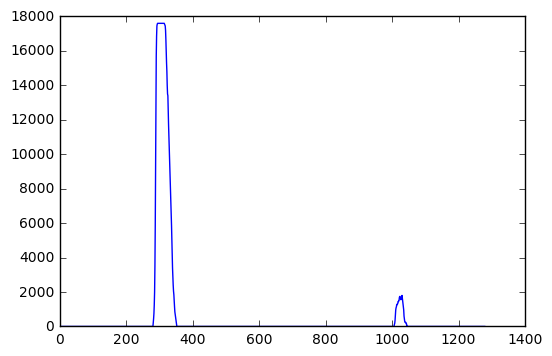

In [5]:
histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
#plt.imshow(warped)
plt.plot(histogram)

In [6]:
def lane_polygon(binary_warped, left_fit, right_fit, min_lefty=0, min_righty=0):
    '''
    Utility function to do generate polygon boundary points based on
    polynomial fits on the left lane and the right lane.
    '''
    #m = min(min_lefty, min_righty)
    m = 0
    min_lefty = m
    min_righty = m
    left_ploty = np.linspace(min_lefty, binary_warped.shape[0]-1, binary_warped.shape[0]-min_lefty)
    left_fitx = left_fit[0]*left_ploty**2 + left_fit[1]*left_ploty + left_fit[2]
    right_ploty = np.linspace(min_righty, binary_warped.shape[0]-1, binary_warped.shape[0]-min_righty)
    right_fitx = right_fit[0]*right_ploty**2 + right_fit[1]*right_ploty + right_fit[2]
    left_line_pts = np.array([np.transpose(np.vstack([left_fitx, left_ploty]))])
    right_line_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_ploty])))])
    lane_pts = np.hstack((left_line_pts, right_line_pts))
    return lane_pts

def generate_lane_image(binary_warped, left_fit, right_fit, min_lefty, min_righty):
    '''
    Draw an image with the lane area filled with color
    '''
    ydim = binary_warped.shape[0]
    xdim = binary_warped.shape[1]
    image = np.zeros(shape=(ydim, xdim, 3), dtype=np.uint8)
    lane_pts = lane_polygon(binary_warped, left_fit, right_fit, min_lefty, min_righty)
    cv2.fillPoly(image, np.int_([lane_pts]), (0, 255, 0))
    return image

/home/xjin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


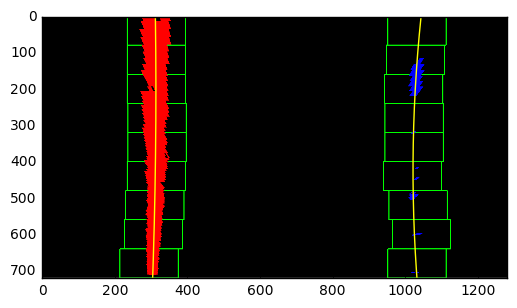

In [7]:
from enum import Enum

# NOT USED
class LaneColor(Enum):
    Yellow = 1
    White = 2
    Unknown = 3

# NOT USED
def lane_color(mean_value):
    bound = 3.0
    # binary_warped has 10 as yellow
    if abs(mean_value-10) < bound:
        return LaneColor.Yellow
    # binary_warped has 20 for white
    elif abs(mean_value-20) < bound:
        return LaneColor.White
    else:
        return LaneColor.Unknown

# Fit second order polynomials based on sliding window.
def fit_polynomials_with_sliding_window(binary_warped, visualize=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #print(leftx_base, rightx_base)
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    yellow = np.where(binary_warped == 50)
    yellowy = np.array(yellow[0])
    yellowx = np.array(yellow[1])
    # yellow color and s channel
    #syellow = np.where((binary_warped == 50) | (binary_warped == 10))
    syellow = np.where((binary_warped == 50))
    syellowy = np.array(syellow[0])
    syellowx = np.array(syellow[1])
    white = np.where(binary_warped == 60)
    whitey = np.array(white[0])
    whitex = np.array(white[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 100
    
    if len(yellowx) < minpix:
        print("No yellow color in frame")
        return None, None, None, None, None, None
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    # from both yellow and s channel
    left_lane_inds_2nd = []
    right_lane_inds = []

    leftx_current_window = -0.5
    rightx_current_window = -0.5
    left_lane_color = LaneColor.Unknown
    right_lane_color = LaneColor.Unknown
    # an estimate of lane width if both the left and right windows have detection
    reference_lane_width = rightx_base - leftx_base
    left_linear_fit = None
    right_linear_fit = None
    # Step through the windows one by one
    fantom_leftx = np.empty([0], dtype=np.int64)
    fantom_lefty = np.empty([0], dtype=np.int64)
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        average_y = 0.5*(win_y_low+win_y_high)
        leftx_anticipated = leftx_current
        if left_linear_fit is not None:
            leftx_anticipated = int(left_linear_fit[0]*average_y+left_linear_fit[1])
        elif right_linear_fit is not None:
            leftx_anticipated = int(right_linear_fit[0]*average_y+right_linear_fit[1]-reference_lane_width)
        rightx_anticipated = rightx_current
        if right_linear_fit is not None:
            rightx_anticipated = int(right_linear_fit[0]*average_y+right_linear_fit[1])
        elif left_linear_fit is not None:
            rightx_anticipated = int(left_linear_fit[0]*average_y+left_linear_fit[1]+reference_lane_width)
        #win_xleft_low = leftx_current - margin
        #win_xleft_high = leftx_current + margin
        #win_xright_low = rightx_current - margin
        #win_xright_high = rightx_current + margin
        win_xleft_low = leftx_anticipated - margin
        win_xleft_high = leftx_anticipated + margin
        win_xright_low = rightx_anticipated - margin
        win_xright_high = rightx_anticipated + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        #good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) 
        #                  & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_left_inds = ((yellowy >= win_y_low) & (yellowy < win_y_high) 
                          & (yellowx >= win_xleft_low) & (yellowx < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        used_syellow = False
        good_left_inds_2nd = []
        if len(good_left_inds) < minpix and window - leftx_current_window == 1:
            # search both yellow and s channel with half the margin
            win_xleft_low = int(leftx_anticipated - margin/2)
            win_xleft_high = int(leftx_anticipated + margin/2)
            good_left_inds_2nd = ((syellowy >= win_y_low) & (syellowy < win_y_high) 
                              & (syellowx >= win_xleft_low) & (syellowx < win_xleft_high)).nonzero()[0]
            used_syellow= True
            left_lane_inds_2nd.append(good_left_inds_2nd)
        else:
            left_lane_inds.append(good_left_inds)
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        
        # Append these indices to the lists
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        left_detected = False
        right_detected = False
        if len(good_left_inds) > minpix or len(good_left_inds_2nd) > minpix:
            #leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if used_syellow:
                leftx_current = np.int(np.mean(syellowx[good_left_inds_2nd]))
            else:
                leftx_current = np.int(np.mean(yellowx[good_left_inds]))
            leftx_current_window = window
            left_detected = True
            inds = np.concatenate(left_lane_inds)
            xs = yellowx[inds]
            ys = yellowy[inds]
            if len(left_lane_inds_2nd) > 0:
                inds_2nd = np.concatenate(left_lane_inds_2nd)
                xs = np.append(xs, syellowx[inds_2nd])
                ys = np.append(ys, syellowy[inds_2nd])
            left_linear_fit = np.polyfit(ys, xs, 1)
            #rint('window', window, 'left_linear_fit', left_linear_fit)
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            rightx_current_window = window
            right_detected = True
            inds = np.concatenate(right_lane_inds)
            xs = nonzerox[inds]
            ys = nonzeroy[inds]
            if np.max(ys) - np.min(ys) > 150:
                right_linear_fit = np.polyfit(ys, xs, 1)
                if not left_detected:
                    #print('before fantom', fantom_leftx.shape, fantom_lefty.shape, len(fantom_leftx))
                    fantom_leftx = np.append(fantom_leftx, xs-reference_lane_width)
                    fantom_lefty = np.append(fantom_lefty, ys)
                    #print('after fantom', fantom_leftx.shape, fantom_lefty.shape)
            #print('window', window, 'right_linear_fit', right_linear_fit)
        if left_detected and right_detected:
            reference_lane_width = rightx_current - leftx_current
        

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    if len(left_lane_inds_2nd) > 0:
        left_lane_inds_2nd = np.concatenate(left_lane_inds_2nd)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = yellowx[left_lane_inds]
    lefty = yellowy[left_lane_inds]
    if len(left_lane_inds_2nd) > 0:
        leftx = np.append(leftx, syellowx[left_lane_inds_2nd])
        lefty = np.append(lefty, syellowy[left_lane_inds_2nd])
    #if len(fantom_leftx) > 0:
    #    leftx = np.append(leftx, fantom_leftx)
    #    lefty = np.append(lefty, fantom_lefty)
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if len(lefty) == 0 or len(righty) == 0:
        return None, None, None, None, None, None
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if visualize:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[yellowy[left_lane_inds], yellowx[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        # lane_pts = lane_polygon(binary_warped, left_fit, right_fit)
        # cv2.fillPoly(out_img, np.int_([lane_pts]), (0,64, 0))
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit, leftx, lefty, rightx, righty

left_fit, right_fit, leftx, lefty, rightx, righty = fit_polynomials_with_sliding_window(warped, visualize=True)

/home/xjin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:56: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 42823 but corresponding boolean dimension is 39327


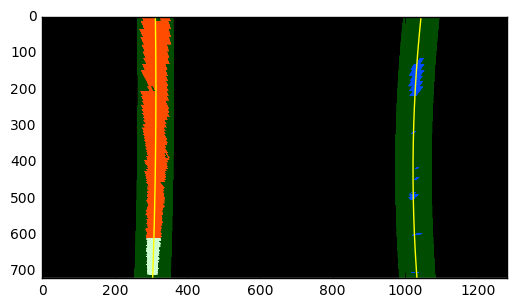

In [8]:
def update_polynomials(binary_warped, left_fit, right_fit, visualize=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    yellow = np.where((binary_warped == 50) | (binary_warped == 10))
    yellowy = np.array(yellow[0])
    yellowx = np.array(yellow[1])
    white = np.where(binary_warped == 60)
    whitey = np.array(white[0])
    whitex = np.array(white[1])
    margin = 50
    if left_fit is None or right_fit is None or len(yellowx) < 100:
        return None, None, None, None, None, None
    
    #left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) 
    #+ left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
    #(nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    left_lane_inds = ((yellowx > (left_fit[0]*(yellowy**2) + left_fit[1]*yellowy + left_fit[2] - margin)) 
                      & (yellowx < (left_fit[0]*(yellowy**2) + left_fit[1]*yellowy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    #leftx = nonzerox[left_lane_inds]
    #lefty = nonzeroy[left_lane_inds] 
    leftx = yellowx[left_lane_inds]
    lefty = yellowy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    min_y_span = 150
    
    if len(lefty) == 0 or len(righty) == 0:
        return None, None, None, None, None, None
    lefty_span = np.max(lefty) - np.min(lefty)
    righty_span = np.max(righty) - np.min(righty)
    if lefty_span < min_y_span or righty_span < min_y_span:
        return None, None, None, None, None, None
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if visualize:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        # print(left_line_window1.shape)
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return left_fit, right_fit, leftx, lefty, rightx, righty

left_fit, right_fit, leftx, lefty, rightx, righty = update_polynomials(warped, left_fit, right_fit, visualize=True)


In [9]:
def calculate_curvature_and_center(leftx, lefty, rightx, righty):
    '''
    Calculates the curvatures of the two lane lines and the distance
    between the center of the lane and the car's center position
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/780 # meters per pixel in x dimension
    y_eval = 720*ym_per_pix
    car_center_x = 640*xm_per_pix
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    #left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / (2*left_fit_cr[0])
    #right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / (2*right_fit_cr[0])
    left_bottom_x = left_fit_cr[0]*y_eval**2+left_fit_cr[1]*y_eval+left_fit_cr[2]
    right_bottom_x = right_fit_cr[0]*y_eval**2+right_fit_cr[1]*y_eval+right_fit_cr[2]
    lane_center_x = (left_bottom_x + right_bottom_x) / 2.0
    car_off_center = car_center_x - lane_center_x
    lane_width = right_bottom_x - left_bottom_x
    return left_curverad, right_curverad, car_off_center, lane_width

updated = leftx != None and rightx != None
if updated:
    left_curverad, right_curverad, off_center, lane_width = calculate_curvature_and_center(
        leftx, lefty, rightx, righty)
    print(left_curverad, 'm,', right_curverad, 'm,', off_center, 'm', lane_width, 'm')
else:
    print("update_polynomial failed")

#lane_polygon_pts = lane_polygon(warped, left_fit, right_fit)




5413.17019895 m, 1485.51109918 m, -0.13228931483 m 3.45159508695 m


/home/xjin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:27: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(720, 1280, 3)


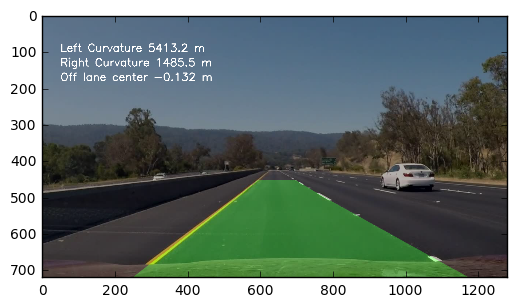

In [10]:
if updated:
    lane_img = generate_lane_image(warped, left_fit, right_fit, np.min(lefty), np.min(righty))

    lane_img = cv2.warpPerspective(lane_img, Minv, (img.shape[1], img.shape[0]),
                                     flags=cv2.INTER_LINEAR)

    print(lane_img.shape)

    overlayed_img = cv2.addWeighted(img,0.7,lane_img,0.3,0)

    font = cv2.FONT_HERSHEY_SIMPLEX
    description = 'Left Curvature {:.1f} m'.format(left_curverad)
    cv2.putText(overlayed_img, description,(50,100), font, 1,(255,255,255),2)
    description = 'Right Curvature {:.1f} m'.format(right_curverad)
    cv2.putText(overlayed_img, description,(50,140), font, 1,(255,255,255),2)
    description = 'Off lane center {:.3f} m'.format(off_center)
    cv2.putText(overlayed_img, description,(50,180), font, 1,(255,255,255),2)


    plt.imshow(overlayed_img)

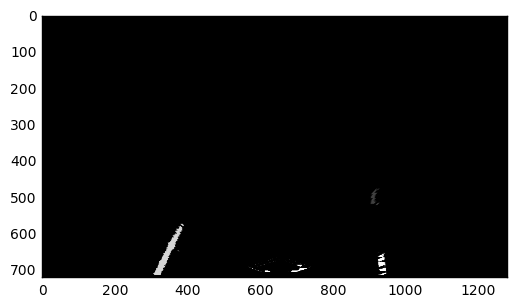

In [11]:
# NOT USED, to test a frame from the challenge video.
def test_image(filename):
    img = mpimg.imread(filename)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ksize = 3
    # Threshold x gradient
    sxbinary = abs_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    # sxbinary = combined_sobel(img)
    sobel_binary = sxbinary
    
    # Threshold color channel
    s_binary = hls_filter(img, thresh=(20, 255))
    filtered_img = combined_filters2(img, sth=(35, 100),
                                     #y=([0, 80, 200], [40, 255, 255]),
                                     #w=([0, 0, 180], [255, 100, 255]))
                                    #y=([0, 80, 150], [40, 255, 255]),
                                     #w=([0, 0, 180], [255, 100, 255]))
                                    y=([0, 100, 100], [50, 255, 255]),
                                    #w=([20, 0, 180], [255, 80, 255]))
                                     w=([20, 0, 180], [255, 80, 255]))
    #filtered_img = combined_filters(img)
    warped = cv2.warpPerspective(filtered_img, M,
                                 (img.shape[1], img.shape[0]),
                                 flags=cv2.INTER_LINEAR)
    plt.imshow(warped, cmap='gray')
    
test_image('./output_images/sampled_challenge_frame.jpg')\



In [12]:
# NOT USED: example class from the lecture to track lanes.
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

# A tracker that tracks the lane detection results and keep up the statistics.
class LaneTracker():
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.detected = False
        self.left_fit = None
        self.right_fit = None
        self.min_lefty = 0
        self.min_righty= 0
        self.update_counter = 0
        self.sliding_window_counter = 0
        self.min_lane_width = -1.0
        self.max_lane_width = -1.0
        self.min_radius = -1.0
        self.max_radius = -1.0
        self.failures = 0
        self.recent_failures = 0
        self.max_consecutive_failures = 0

    def set_results(self, left_fit, right_fit, left_curverad, lane_width,
                    update, min_lefty, min_righty):
        self.detected = True
        self.left_fit = left_fit
        self.right_fit = right_fit
        self.min_lefty = min_lefty
        self.min_righty = min_righty
        if update:
            self.update_counter += 1
        else:
            self.sliding_window_counter +=1
        if self.min_lane_width == -1.0 or self.min_lane_width > lane_width:
            self.min_lane_width = lane_width
        if self.max_lane_width == -1.0 or self.max_lane_width < lane_width:
            self.max_lane_width = lane_width
        if self.min_radius == -1.0 or self.min_radius > left_curverad:
            self.min_radius = left_curverad
        if self.max_radius == -1.0 or self.max_radius < left_curverad:
            self.max_radius = left_curverad
        self.recent_failures = 0
    
    def set_failure(self):
        self.recent_failures += 1
        if self.recent_failures > self.max_consecutive_failures:
            self.max_consecutive_failures = self.recent_failures
        # print("Detection failure!!! recent_failures is now %d" % self.recent_failures)
        self.failures += 1
            
    def report(self):
        print("Used sliding window {} times, and updates {} times.",
              self.sliding_window_counter, self.update_counter)
        print("Radius range [%.2f m, %.2f m]" % (self.min_radius, self.max_radius))
        print("Lane width range [%.2f m, %.2f m]" % (self.min_lane_width, self.max_lane_width))
        print("Total detection failures: %d, max consecutive failures %d"
              % (self.failures, self.max_consecutive_failures))

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lane_tracker = LaneTracker()

# Check if the polynomial fits are correct
def valid_detection(left_fit, right_fit):
    return left_fit is not None and right_fit is not None

# Check if the lane detection results are valid, based on curvatures,
# lane width, and off center values.
def valid_lane(left_curverad, right_curverad, off_center, lane_width):
    '''
    Based on calculated lane statistics, decide if the detection is valid
    or not.
    '''
    if lane_width < 2.0 or lane_width > 4.5:
        return False
    if off_center > 0.5:
        return False
    return True

# A function that detects lanes from the warped perspective image and record
# detection results in the tracker.
def detect_on_warped_image(binary_warped, final_try=True):
    '''
    Detect lanes on a warped image.
    final_try: whether this is the last try
    '''
    do_sliding_window = True
    ok = False
    left_curverad = right_curverad = off_center = 0
    if lane_tracker.detected:
        left_fit, right_fit, leftx, lefty, rightx, righty = update_polynomials(
            binary_warped, lane_tracker.left_fit, lane_tracker.right_fit)
        if not valid_detection(left_fit, right_fit):
            #print("Invalid update detection")
            pass
        else:
            left_curverad, right_curverad, off_center, lane_width = calculate_curvature_and_center(
                leftx, lefty, rightx, righty)
            if not valid_lane(left_curverad, right_curverad, off_center, lane_width):
                #print("Invalid update lane: %.2f %.2f %.2f %.2f"
                #      % (left_curverad, right_curverad, off_center, lane_width))
                pass
            else:
                do_sliding_window = False
                lane_tracker.set_results(left_fit, right_fit, left_curverad, lane_width,
                                         update=True, min_lefty=np.min(lefty),
                                         min_righty=np.min(righty))
                ok = True
    if do_sliding_window:
        left_fit, right_fit, leftx, lefty, rightx, righty = fit_polynomials_with_sliding_window(
            binary_warped)
        if not valid_detection(left_fit, right_fit):
            print("Invalid sliding window detection")
            if final_try:
                lane_tracker.set_failure()
        else:
            left_curverad, right_curverad, off_center, lane_width = calculate_curvature_and_center(
                leftx, lefty, rightx, righty)
            if valid_lane(left_curverad, right_curverad, off_center, lane_width):
                lane_tracker.set_results(left_fit, right_fit, left_curverad, lane_width,
                                         update=False, min_lefty=np.min(lefty),
                                         min_righty=np.min(righty))
                ok = True
            else:
                print("Invalid sliding window lane: %.2f %.2f %.2f %.2f"
                      % (left_curverad, right_curverad, off_center, lane_width))
                if final_try:
                    lane_tracker.set_failure()
    return ok, left_curverad, right_curverad, off_center

err_counter = 0

# Process each video frame, to detect lanes and draw them on an overlay image for output video.
def process_image(img):
    global err_counter
    binary_warped = lane_warp(img, enable_sobel=True)
    ok, left_curverad, right_curverad, off_center = detect_on_warped_image(binary_warped, final_try=False)
    
    if ok:
        lane_img = generate_lane_image(binary_warped, lane_tracker.left_fit,
                                       lane_tracker.right_fit, lane_tracker.min_lefty,
                                      lane_tracker.min_righty)
        lane_img = cv2.warpPerspective(lane_img, Minv, (img.shape[1], img.shape[0]),
                                 flags=cv2.INTER_LINEAR)
        overlayed_img = cv2.addWeighted(img, 0.7, lane_img, 0.3,0)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        description = 'Left Curvature {:.1f} m'.format(left_curverad)
        cv2.putText(overlayed_img, description,(50,100), font, 1,(255,255,255),2)
        description = 'Right Curvature {:.1f} m'.format(right_curverad)
        cv2.putText(overlayed_img, description,(50,140), font, 1,(255,255,255),2)
        description = 'Off lane center {:.3f} m'.format(off_center)
        cv2.putText(overlayed_img, description,(50,180), font, 1,(255,255,255),2)
    else:
        overlayed_img = img
        #print("Missing detection on image")
        err_counter += 1
        mpimg.imsave('test/test{}.jpg'.format(err_counter), img)
        
    return overlayed_img

def process_video(filename):
    global lane_tracker
    lane_tracker.reset()
    clip = VideoFileClip(filename)
    processed_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
    %time processed_clip.write_videofile('result_' + filename, audio=False)
    lane_tracker.report()


In [14]:
# Handle the project video, generates the output.
process_video('project_video.mp4')

[MoviePy] >>>> Building video result_project_video.mp4
[MoviePy] Writing video result_project_video.mp4


100%|█████████▉| 1260/1261 [02:18<00:00,  8.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_project_video.mp4 

CPU times: user 9min 35s, sys: 16.1 s, total: 9min 51s
Wall time: 2min 19s
Used sliding window {} times, and updates {} times. 1 1260
Radius range [268.91 m, 439754849.59 m]
Lane width range [3.20 m, 3.96 m]
Total detection failures: 0, max consecutive failures 0


In [15]:
#process_video('challenge_video.mp4')


In [16]:
#process_video('harder_challenge_video.mp4')